<h1 align=center><font size = 5>IBM Applied Data Science Capstone Project</font></h1>

## Introduction

This Jupyter Notebook includes the Applied Data Science Project implemebted by [Georgios Trakakis](https://www.linkedin.com/in/georgios-trakakis/?originalSubdomain=uk) for the purposes of the [IBM Data Science Professional Specialization](https://www.coursera.org/professional-certificates/ibm-data-science)

## Project Description

London is a major global city and world cultural capital, with strengths in the arts, commerce, education, entertainment, fashion, finance, healthcare, media, professional services, research and development, tourism, and transportation. A major settlement for 2,000 years, London is the world's largest financial centre and the 5th or 6th richest city in the world. The property investment capital of the UK, London has a diverse array of housing and communities across a giant urban area. You can find different types of long-let investment property in various areas to suit most budgets, and being the world's most-visited city as measured by international arrivals means there is no shortage of short-let opportunities too. Having the largest concentration of higher education institutes in Europe guarantees that London has an active student property rental market as well.

The above reasons constitute London one of the most expensive places for someone to live.Demand for housing and real estate continues to be robust despite Brexit uncertainty.While it is clear that the UK Parliament wishes to avoid a no-deal Brexit, there is little consensus about what form a future arrangement with the EU should take.

The main objective of this survey is to examine what factors influence most the price of a real estate assets and which houses will be less inelastic to demand should a No deal Brexit occurs.How can the surroundings venues influence the price of the asset and in what extend?Which factor has the larger influence on the price of the asset?
The above survey will help real estate investors to focus on regions that have surrounding venues and amenities that drive the price of the housing up.Therefore,should Brexit occur,their losses will be minimum in terms of asset devaluation.

## Data Description

The data that will be used for this project will be acquired from the following sources:

* The Neighbourhoods of London and their postcodes using Wikipedia(https://en.wikipedia.org/wiki/List_of_areas_of_London)
* The average prices of properies by neighbourhood and by £/sqft in London(https://propertydata.co.uk/cities/london)
* The venues in each Neighbourhood in London area(https://developer.foursquare.com/)
* Coordinates of each Neighbourhood/postcode using geocoder python library(https://developers.arcgis.com/python/guide/using-the-geocode-function/)
   
    
    
    

<i><u> Note on Data:</u> The data will only include the price of each propery using £/sqft since we do not want to consider properties that have different attributes(e.g 2 bathrooms or 3 bedrooms) which will create noise in our survey.

## Project Steps

1) Scrape the Neighbourhoods html data from Wikipedia using Beautiful Soup library or pandas.read_html method.

2) Scrape the Propery prices from html format on the internet to dataframe using Beautiful Soup library or pandas.read_html method.

3) Explore the Venues in each Neighbourhood using Foursquare API.

4) Get the latitude and longitude data using Geocoder.Arcgis library.

5) Scrape all the data above and combine them into one dataframe.

6) Group by Neighbourhood and count the occurrences of each venue type for each Neighbourhood.

7) Cluster each Neighbourhood based on their venues and add the cluster back into the initial dataframe

8) Identify patterns in each cluster and the most common venues.Explore what causes the increased price of the property based on the venues.

9) In the initial datafame without the labels we will implement multiple linear regression in order to quantify the impact-weight of each venue in the price of the properties.

10) Try PCA (Principal Component Analysis) PCA regression in order to find the venues that have the most impact and reduce the dimension of our data.

11) Write the summary of our results

## <strong><u> Part 1: Data Scrapping and Preparation

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
# uncomment the lines below if you haven't the libraries in your environment
#!conda install -c conda-forge geopy --yes 
!pip install geopy
#!conda install -c conda-forge geocoder --yes  
!pip install geocoder
#!conda install -c conda-forge folium=0.5.0 --yes
!pip install folium
!pip install beautifulsoup4 
!pip install lxml 
!pip install split

In [3]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis

pd.set_option('display.max_columns', None) #If set to None, the number of items to be printed is unlimited
pd.set_option('display.max_rows', None)    ##If set to None, the number of items to be printed is unlimited

import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library

from bs4 import BeautifulSoup
import string

from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib as plt
from matplotlib import pyplot

print('Libraries imported.')

Libraries imported.


### Let's load the data from Wikipedia page

#### 1st way using Beautiful Soup

In [4]:
import requests  #The requests library is the de facto standard for making HTTP requests in Python.

#Lets examine it further in our example to see if indeed the data are in json format
url = 'https://en.wikipedia.org/wiki/List_of_areas_of_London'
response = requests.get(url)  
print(response)  #For example, a 200 OK status means that your request was successful, whereas a 404 NOT FOUND status means that the resource you were looking for was not found
print(response.status_code)
if 'json' in response.headers.get('Content-Type'):
    js = response.json()
else:
    print('Response content is not in JSON format.')
    js = 'spam'

<Response [200]>
200
Response content is not in JSON format.


Usually if you take a look at the repsonse you can undestand if it is a json file or not.Here it is not.Thus you cannot use the json.load method or json() method and then use the json normalize method to convert them into a dataframe.As you observe the data in the wikipedia page are not in json format.Thus we cannot use the json normalize method to get the data into a pandas dataframe. Therefore we will have to read a html file with a different way.That is why we use BeatifulSoup Library or the pandas_html method.We will do both.
__pandas.read_html :__ Reads HTML tables into a list of DataFrame objects.

In [5]:
response = requests.get('https://en.wikipedia.org/wiki/List_of_areas_of_London').text
#if you did not use text then you wouldn't have the result.you would have the 200 results which shows that the connection was successful.Witout text you will have:<Response [200]>

In [6]:
soup=BeautifulSoup(response,'lxml')
#print(soup.prettify())

In [7]:
print(soup.title.text)

List of areas of London - Wikipedia


Finding the headers of our dataframe

In [8]:
table = soup.find('table',class_='wikitable sortable')
table.tr.text 

'\nLocation\nLondon\xa0borough\nPost town\nPostcode\xa0district\nDial\xa0code\nOS grid ref\n'

In [9]:
headers=table.tr.text.split("\n")
headers

['',
 'Location',
 'London\xa0borough',
 'Post town',
 'Postcode\xa0district',
 'Dial\xa0code',
 'OS grid ref',
 '']

In [10]:
del headers[0]
del headers[-1]
headers

['Location',
 'London\xa0borough',
 'Post town',
 'Postcode\xa0district',
 'Dial\xa0code',
 'OS grid ref']

In [11]:
headers=[i.split()[0] for i in headers]
headers

['Location', 'London', 'Post', 'Postcode', 'Dial', 'OS']

In [12]:
headers[2]="Post town"
headers[5]="OS grid ref"
headers[4]="Dial code"
headers

['Location', 'London', 'Post town', 'Postcode', 'Dial code', 'OS grid ref']

Finding the contents of our dataframe

In [13]:
table = soup.find('table',class_='wikitable sortable')
#print(table)
#print(table.find_all('tr'))  #gives you a list.

In [14]:
print(table.find_all('tr')[0])  #select the first element of the list 
print(table.find_all('tr')[0].text)  #making the element a text
print(table.find_all('tr')[1]) 
print(table.find_all('tr')[1].text)

<tr>
<th>Location</th>
<th>London borough</th>
<th>Post town</th>
<th>Postcode district</th>
<th>Dial code</th>
<th>OS grid ref
</th></tr>

Location
London borough
Post town
Postcode district
Dial code
OS grid ref

<tr>
<td><a href="/wiki/Abbey_Wood" title="Abbey Wood">Abbey Wood</a></td>
<td>Bexley,  Greenwich <sup class="reference" id="cite_ref-mills1_7-0"><a href="#cite_note-mills1-7">[7]</a></sup></td>
<td>LONDON</td>
<td>SE2</td>
<td>020</td>
<td><span class="plainlinks nourlexpansion" style="white-space: nowrap"><a class="external text" href="https://tools.wmflabs.org/geohack/en/51.48648031512;0.10859224316653_region:GB_scale:25000?pagename=List_of_areas_of_London">TQ465785</a></span>
</td></tr>

Abbey Wood
Bexley,  Greenwich [7]
LONDON
SE2
020
TQ465785



In [15]:
#The above should be made into a list of lists
import pandas as pd
row=[]
for tr in table.find_all('tr'):
    data = (tr.find_all('td'))
    row.append([i.text.strip() for i in data])

df1=pd.DataFrame(data=row)
df1=df1.iloc[1:]
df1.columns=headers
df1.reset_index(drop=True,inplace=True)
df1.head()

,Location,London,Post town,Postcode,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


#### 2nd way using pandas_html method(much easier)

In [16]:
lista = pd.read_html("https://en.wikipedia.org/wiki/List_of_areas_of_London",header=0)
type(lista)  #pandas.read_html : Reads HTML tables into a list of DataFrame objects.
#lista  #Remove # if you want to see the list of datafranes
#As you can see the first element in the list are the titles while the second element [1] is the dataframe that we need

list

In [17]:
df1= lista[1]

In [18]:
df1.head()

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


In [19]:
print(df1.columns)
#Let's change the name of the columns:
df1.columns = ['Location','Borough','Post_Town','Postcode','DialCode','OS_grid_ref']
print(df1.columns)

Index(['Location', 'London borough', 'Post town', 'Postcode district',
       'Dial code', 'OS grid ref'],
      dtype='object')
Index(['Location', 'Borough', 'Post_Town', 'Postcode', 'DialCode',
       'OS_grid_ref'],
      dtype='object')


In [20]:
#Lets clean our dataframe:
#1st let's remove the huperlinks from the Borough column

for index,value in enumerate(df1['Borough']):
    #print(i.split('[')[0])
    df1.at[index,'Borough']=value.split('[')[0]  ##DataFrame.at--->Access a single value for a row/column label pair.
#or another way would be to use itterows:for i, row in df.iterrows()
df1['Borough'].head()

0                Bexley, Greenwich 
1    Ealing, Hammersmith and Fulham
2                           Croydon
3                           Croydon
4                            Bexley
Name: Borough, dtype: object

In [21]:
#As we observe from above the 1st element has a space at the end and also the 1st and 2nd have two Borough so let's fix it
#1st method: Use a similar process as we did above

#2nd method:
#The str method will be used below which does the same as the code above:
#Series.str()--->Vectorized string functions for Series and Index.  Patterned after Python’s string methods.Returns:pandas.core.strings.StringMethods
#series.str.split()--->Splits the string in the Series/Index from the beginning, at the specified delimiter string.
#df['Borough'] =  df['Borough'].str.split(',').str[0]
#df['Borough'].head()

#3rd method:
df1['Borough'] =  df1['Borough'].apply(lambda x: x.split(",")[0])

In [22]:
df1.head()

,Location,Borough,Post_Town,Postcode,DialCode,OS_grid_ref
0,Abbey Wood,Bexley,LONDON,SE2,020,TQ465785
1,Acton,Ealing,LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon,CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


In [23]:
#Let's do the same with Postcode and for Post_town and keep only the first one:
df1['Postcode'] =  df1['Postcode'].apply(lambda x: x.split(",")[0])
df1['Post_Town'] =  df1['Post_Town'].apply(lambda x: x.split(",")[0])

In [24]:
df1.head()

,Location,Borough,Post_Town,Postcode,DialCode,OS_grid_ref
0,Abbey Wood,Bexley,LONDON,SE2,020,TQ465785
1,Acton,Ealing,LONDON,W3,020,TQ205805
2,Addington,Croydon,CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,BEXLEY,DA5,020,TQ478728


In [25]:
df1.drop(columns=['Post_Town','DialCode','OS_grid_ref'],inplace=True)
df1.head()

,Location,Borough,Postcode
0,Abbey Wood,Bexley,SE2
1,Acton,Ealing,W3
2,Addington,Croydon,CR0
3,Addiscombe,Croydon,CR0
4,Albany Park,Bexley,DA5


In [26]:
df1.dtypes

Location    object
Borough     object
Postcode    object
dtype: object

In [27]:
#Convert everything in the dataframe to string
df1 = df1.astype(str)
df1.dtypes
##since strings data types have variable length, it is by default stored as object dtype. If you want to store them as string type, you can do something like this.
#df1= df1.astype('|S80') #where the max length is set at 80 bytes,

Location    object
Borough     object
Postcode    object
dtype: object

In [28]:
df1.sort_values(by='Postcode',ascending=True,inplace=True)
df1.reset_index(drop=True,inplace=True)
df1.head()

,Location,Borough,Postcode
0,Bromley,Bromley,BR1
1,Downham,Lewisham,BR1
2,Sundridge,Bromley,BR1
3,Widmore (also Widmore Green),Bromley,BR1
4,Plaistow,Bromley,BR1


In [29]:
df1.shape

(533, 3)

### Let's load the property data from [London property page](https://propertydata.co.uk/cities/london)

In [30]:
lista2 = pd.read_html("https://propertydata.co.uk/cities/london",header=0)
df2=lista2[0]
df2.head()

,Area,Avg yield,Avg price,£/sqft,5yr +/-,Explore data
0,BR1,3.4%,"£431,225",£460,+24%,Explore data
1,BR2,3.7%,"£480,982",£468,+23%,Explore data
2,BR3,3.6%,"£457,497",£483,+23%,Explore data
3,BR4,-,"£593,348",£458,+23%,Explore data
4,BR5,3.1%,"£434,246",£418,+25%,Explore data


In [31]:
#Lets clean our dataframe:
#Note that we will use the £/sqft and not the Average price since using £/sqft will make the comparison on £/sqft and will not take into consideration if a real estate asset is larger than the other one.
df2.drop(columns=['Avg yield', 'Avg price', '5yr +/-', 'Explore data'],inplace=True)
df2.head()

,Area,£/sqft
0,BR1,£460
1,BR2,£468
2,BR3,£483
3,BR4,£458
4,BR5,£418


In [32]:
#Remove the £ symbol and convert the column into integer
df2['£/sqft'] =  df2['£/sqft'].apply(lambda x: x.split("£")[-1])
df2.head()

,Area,£/sqft
0,BR1,460
1,BR2,468
2,BR3,483
3,BR4,458
4,BR5,418


In [33]:
df2.columns=['Postcode','£/sqft']
df2.head()

,Postcode,£/sqft
0,BR1,460
1,BR2,468
2,BR3,483
3,BR4,458
4,BR5,418


In [34]:
#Lets inner join the two dataframes 
df=pd.merge(df1, df2, how='inner', left_on='Postcode', right_on='Postcode')
df

,Location,Borough,Postcode,£/sqft
0,Bromley,Bromley,BR1,460
1,Downham,Lewisham,BR1,460
2,Sundridge,Bromley,BR1,460
3,Widmore (also Widmore Green),Bromley,BR1,460
4,Plaistow,Bromley,BR1,460
5,Hayes,Bromley,BR2,468
6,Southborough,Bromley,BR2,468
7,Leaves Green,Bromley,BR2,468
8,Keston,Bromley,BR2,468
9,Bromley Common,Bromley,BR3,483


## <strong><u> Part 2: Get Latitude and Longitude coordinates for each Neighbourhood

Now that you have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.We will use the Geocoder Python package instead: https://geocoder.readthedocs.io/index.html. The problem with this Package is you have to be persistent sometimes in order to get the geographical coordinates of a given postal code. So you can make a call to get the latitude and longitude coordinates of a given postal code and the result would be None, and then make the call again and you would get the coordinates.

In [36]:
#Use geolocator to find the latitudes and longitudes in London
import geopy
address="London,UK"
geolocator = Nominatim(user_agent="London_explorer")
lat_lng_coords = None

while(lat_lng_coords is None):
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    lat_lng_coords=[latitude,longitude]

print('The geograpical coordinate of London are {}, {}.'.format(lat_lng_coords[0], lat_lng_coords[1]))

The geograpical coordinate of London are 51.5073219, -0.1276474.


Now that we got the coordinates of London, let's get the coordinates for each postcode.However here we cannot use the same method as the one we used above since Nominatin can only be used for adresses and not for postcodes.We cannot also use Google API since it is not free anymore and it returns None.I found on internet another great API ,arcgis API.Thus this is what we will use to find the coordinates.

In [37]:
import geocoder
Latitude_list=[]
Longitude_list=[]
for i in range(df.shape[0]):
    address='{}, London,UK'.format(df.at[i,'Postcode'])   #DataFrame.at--->Access a single value for a row/column label pair.
    g = geocoder.arcgis(address)
    #print(g) #returns: <[OK] Arcgis - Geocode [London]>
    Latitude_list.append(g.latlng[0])
    Longitude_list.append(g.latlng[1])

In [38]:
df['Latitude']=Latitude_list
df['Longitude']=Longitude_list

In [39]:
df.head(10)

,Location,Borough,Postcode,£/sqft,Latitude,Longitude
0,Bromley,Bromley,BR1,460,51.416710,0.009042
1,Downham,Lewisham,BR1,460,51.416710,0.009042
2,Sundridge,Bromley,BR1,460,51.416710,0.009042
3,Widmore (also Widmore Green),Bromley,BR1,460,51.416710,0.009042
4,Plaistow,Bromley,BR1,460,51.416710,0.009042
5,Hayes,Bromley,BR2,468,51.506420,-0.127210
6,Southborough,Bromley,BR2,468,51.506420,-0.127210
7,Leaves Green,Bromley,BR2,468,51.506420,-0.127210
8,Keston,Bromley,BR2,468,51.506420,-0.127210
9,Bromley Common,Bromley,BR3,483,51.415095,-0.035403


In [40]:
#Change the name from Location to Neighbourhod
df=df.rename(columns = {'Location':'Neighbourhood'})

In [41]:
df.head()

,Neighbourhood,Borough,Postcode,£/sqft,Latitude,Longitude
0,Bromley,Bromley,BR1,460,51.41671,0.009042
1,Downham,Lewisham,BR1,460,51.41671,0.009042
2,Sundridge,Bromley,BR1,460,51.41671,0.009042
3,Widmore (also Widmore Green),Bromley,BR1,460,51.41671,0.009042
4,Plaistow,Bromley,BR1,460,51.41671,0.009042


#### Create a map of Toronto with neighborhoods superimposed on top.

In [42]:
# create map of London using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng,postcode, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Postcode'],df['Borough'], df['Neighbourhood']):
    label = '{},{}, {}'.format(postcode,neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

## <strong><u> Part 3: Get the venues in each Neighbourhood utilising Foursquare API

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.I have censored my credentials.

#### Define Foursquare Credentials and Version

In [43]:
# The code was removed by Watson Studio for sharing.

In [44]:
# The code was removed by Watson Studio for sharing.

#### Let's create a function to explore the venues to all the neighborhoods in London

In [45]:
def getNearbyVenues(names, latitudes, longitudes, radius=500,LIMIT=100):  #Here you wont use apply  since it makes an itteration by itself in the df columns-series, inside the defined function.Where 
    #names=df['Neighbourhood'],latitudes=df['Latitude'],longitudes=df['Longitude']
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):  
        #Here you wont use apply  since it makes an itteration by itself in the manhattam dataframe columns-series.We can't use also apply since apply is usually used in one column while here we 
        #have more than one columns.We have names,latitude and longitudes
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']   ##This outputs a list for each neighbourhood and has the vanues in each neighbourhood
        
        # return only relevant information for each nearby venue
        venues_list.append([(          #Imports every list to the venues_list
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results]) #here we did not use the get_category_type(row) user defined function since we know that the categories have data in the venues.categories
            #print(venues_list) #### If you want to understand how it passes the data in the list.
            #However you should know that this will take a lot of calculation time.
            #The loop for v in results applies for all the elements in the append,name ,
            #lat,lng,v['venue']['name'],v['venue']['location']['lat'],v['venue']['location']['lng'] and v['venue']['categories'][0]['name']
    
    
    #The venues list will be something like that.I copied paste it from New York example from IBM since I do not want to print it for Toronto ,since it will take a lot of calculation time:
    #[[('Marble Hill', 40.87655077879964, -73.91065965862981, "Arturo's", 40.87441177110231, -73.91027100981574, 'Pizza Place'), 
    #  ('Marble Hill', 40.87655077879964, -73.91065965862981, 'Bikram Yoga', 40.876843690797934, -73.90620384419528, 'Yoga Studio'),........]]
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues) #returns a dataframe which we will later assign it to a value

In [46]:
#If this creates an error then run it again!This has to do with the Foursquare API.
#let's apply this function to our Postcode dataframe:
london_venues = getNearbyVenues(names=df['Neighbourhood'],
                                   latitudes=df['Latitude'],
          
                                longitudes=df['Longitude'])

Bromley
Downham
Sundridge
Widmore (also Widmore Green)
Plaistow
Hayes
Southborough
Leaves Green
Keston
Bromley Common
Bickley
Beckenham
Elmers End
Eden Park
West Wickham
Coney Hall
St Paul's Cray
Petts Wood
Orpington
St Mary Cray
Derry Downs
Chelsfield
Downe
Locksbottom
Pratt's Bottom
Goddington
Hazelwood
Elmstead
Chislehurst
Woodside
Forestdale
Waddon
Croydon
Coombe
New Addington
Addiscombe
Addington
Shirley
Selsdon
Sanderstead
South Croydon
Mitcham
Old Coulsdon
Coulsdon
Thornton Heath
Purley
Kenley
Riddlesdown
Crayford
Barnes Cray
Foots Cray
Ruxley
Upper Ruxley
Sidcup
North Cray
Blackfen
Lamorbey
Welling
East Wickham
Belvedere
Lessness Heath
Dartford
Bexley (also Old Bexley, Bexley Village)
Albany Park
Barnehurst
North End
Northumberland Heath
Erith
Slade Green
Colyers
Mile End
Ratcliff
Stepney
Spitalfields
Wapping
Whitechapel
Shadwell
Leyton
Lea Bridge
Wanstead
Cann Hall
Leytonstone
Snaresbrook
Little Ilford
Manor Park
Plaistow
West Ham
Leamouth
Cubitt Town
Isle of Dogs
Millwall
Lim

In [47]:
london_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Hayes,51.50642,-0.12721,Corinthia Hotel,51.506607,-0.124460,Hotel
1,Hayes,51.50642,-0.12721,Trafalgar Square,51.507987,-0.128048,Plaza
2,Hayes,51.50642,-0.12721,East Trafalgar Square Fountain,51.508088,-0.127700,Fountain
3,Hayes,51.50642,-0.12721,Horse Guards Parade,51.504847,-0.126590,Plaza
4,Hayes,51.50642,-0.12721,ESPA Life at Corinthia,51.506402,-0.125114,Spa


In [48]:
london_venues.shape

(21553, 7)

#### Let's check how many venues were returned for each neighborhood

In [50]:
london_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Abbey Wood,7,7,7,7,7,7
Acton,9,9,9,9,9,9
Addington,1,1,1,1,1,1
Addiscombe,1,1,1,1,1,1
Albany Park,100,100,100,100,100,100
Aldborough Hatch,100,100,100,100,100,100
Aldwych,100,100,100,100,100,100
Alperton,100,100,100,100,100,100
Anerley,6,6,6,6,6,6


#### Let's find out how many unique categories can be curated from all the returned venues

In [51]:
print('There are {} uniques categories.'.format(len(london_venues['Venue Category'].unique())))

There are 315 uniques categories.


#### Analyze Each Neighborhood

In [52]:
london_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Hayes,51.50642,-0.12721,Corinthia Hotel,51.506607,-0.124460,Hotel
1,Hayes,51.50642,-0.12721,Trafalgar Square,51.507987,-0.128048,Plaza
2,Hayes,51.50642,-0.12721,East Trafalgar Square Fountain,51.508088,-0.127700,Fountain
3,Hayes,51.50642,-0.12721,Horse Guards Parade,51.504847,-0.126590,Plaza
4,Hayes,51.50642,-0.12721,ESPA Life at Corinthia,51.506402,-0.125114,Spa


In [53]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="") #Returns new dataframe
london_onehot.head()

,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Betting Shop,Bike Shop,Bistro,Boarding House,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Canal,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Champagne Bar,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cricket Ground,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Knitting Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical School,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Nightclub,Noodle House,North Indian Restaurant,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Palace,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Racetrack,Radio Station,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Recruiting Agency,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Resort,Restaurant,River,Road,Rock Club,Roof Deck,Sake Bar,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shaanxi Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Soccer Field,Soccer Stadium,Social Club,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stables,Statio

In [54]:
# add neighborhood column back to dataframe of dummies
london_onehot['Neighbourhood'] = london_venues['Neighbourhood'] 
london_onehot.head()

,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Betting Shop,Bike Shop,Bistro,Boarding House,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Canal,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Champagne Bar,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cricket Ground,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Knitting Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical School,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Nightclub,Noodle House,North Indian Restaurant,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Palace,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Racetrack,Radio Station,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Recruiting Agency,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Resort,Restaurant,River,Road,Rock Club,Roof Deck,Sake Bar,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shaanxi Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Soccer Field,Soccer Stadium,Social Club,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stables,Statio

In [55]:
# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]
london_onehot.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Betting Shop,Bike Shop,Bistro,Boarding House,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Canal,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Champagne Bar,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cricket Ground,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Knitting Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical School,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Nightclub,Noodle House,North Indian Restaurant,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Palace,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Racetrack,Radio Station,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Recruiting Agency,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Resort,Restaurant,River,Road,Rock Club,Roof Deck,Sake Bar,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shaanxi Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Soccer Field,Soccer Stadium,Social Club,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,

In [56]:
london_onehot.shape

(21553, 316)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [57]:
london_grouped = london_onehot.groupby('Neighbourhood').mean().reset_index()
london_grouped.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Betting Shop,Bike Shop,Bistro,Boarding House,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Canal,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Champagne Bar,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cricket Ground,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Knitting Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical School,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Nightclub,Noodle House,North Indian Restaurant,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Palace,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Racetrack,Radio Station,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Recruiting Agency,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Resort,Restaurant,River,Road,Rock Club,Roof Deck,Sake Bar,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shaanxi Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Soccer Field,Soccer Stadium,Social Club,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,

In [58]:
london_grouped.shape

(506, 316)

#### Let's print each neighborhood along with the top 5 most common venues

In [59]:
num_top_venues = 5

for hood in london_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})  #DataFrame.round(self, decimals=0, *args, **kwargs)[source].Round a DataFrame to a variable number of decimal places.
    #if you had many columns then you could use: temp.round(2) without having to specify the column
    #With a dict, the number of places for specific columns can be specified with the column names as key and the number of decimal places as value
    #e.g. df.round({'dogs': 1, 'cats': 0})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))  #gives you a dataframe
    print('\n')

----Abbey Wood----
               venue  freq
0        Supermarket  0.29
1        Coffee Shop  0.14
2      Train Station  0.14
3           Platform  0.14
4  Convenience Store  0.14


----Acton----
               venue  freq
0    Bed & Breakfast  0.11
1     Breakfast Spot  0.11
2      Train Station  0.11
3  Convenience Store  0.11
4               Park  0.11


----Addington----
               venue  freq
0      Grocery Store   1.0
1  Accessories Store   0.0
2               Park   0.0
3           Pharmacy   0.0
4          Pet Store   0.0


----Addiscombe----
               venue  freq
0      Grocery Store   1.0
1  Accessories Store   0.0
2               Park   0.0
3           Pharmacy   0.0
4          Pet Store   0.0


----Albany Park----
                 venue  freq
0                Hotel  0.06
1              Theater  0.05
2               Garden  0.04
3                Plaza  0.04
4  Monument / Landmark  0.04


----Aldborough Hatch----
                 venue  freq
0                Hotel  

In [60]:
london_grouped.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Betting Shop,Bike Shop,Bistro,Boarding House,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Canal,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Champagne Bar,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cricket Ground,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Knitting Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical School,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Nightclub,Noodle House,North Indian Restaurant,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Palace,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Racetrack,Radio Station,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Recruiting Agency,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Resort,Restaurant,River,Road,Rock Club,Roof Deck,Sake Bar,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shaanxi Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Soccer Field,Soccer Stadium,Social Club,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [61]:
def return_most_common_venues(row, num_top_venues=10):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [62]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd'] #Will be used for the columns in the new dataframe

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        #it goes here after the 3 first data since after that you have th is each nymber e.g 4th,5th etc.
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
london_neigh_venues_sorted = pd.DataFrame(columns=columns)
london_neigh_venues_sorted['Neighbourhood'] = london_grouped['Neighbourhood']  #passed the data in our dataframe for the first column Nieghbourhood


#Lets pass the data in the dataframe
for ind in np.arange(london_grouped.shape[0]):
    london_neigh_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)  #ind here is 0 so it return the first row which has an index of 0.
    #The columns that start from 1: to the end are picked inside the defined function.
    #neighborhoods_venues_sorted.iloc[ind, 1:] means ind row which starts from 0 and columns from 1 to the end ,since the 1st column is already filled
    
london_neigh_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbey Wood,Supermarket,Platform,Historic Site,Coffee Shop,Train Station,Convenience Store,Flea Market,Flower Shop,Food,Food & Drink Shop
1,Acton,Gas Station,Miscellaneous Shop,Breakfast Spot,Indian Restaurant,Train Station,Park,Bed & Breakfast,Convenience Store,Grocery Store,Zoo Exhibit
2,Addington,Grocery Store,Zoo Exhibit,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest
3,Addiscombe,Grocery Store,Zoo Exhibit,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest
4,Albany Park,Hotel,Theater,Garden,Monument / Landmark,Plaza,Spa,Wine Bar,Mexican Restaurant,Art Gallery,Sandwich Place


## <strong><u> Part 4: Clustering Neighbourhoods

In [63]:
london_grouped.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Betting Shop,Bike Shop,Bistro,Boarding House,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Canal,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Champagne Bar,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cricket Ground,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Knitting Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical School,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Nightclub,Noodle House,North Indian Restaurant,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Palace,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Racetrack,Radio Station,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Recruiting Agency,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Resort,Restaurant,River,Road,Rock Club,Roof Deck,Sake Bar,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shaanxi Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Soccer Field,Soccer Stadium,Social Club,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,

In [64]:
# set number of clusters
#kclusters = ???How many clusters is will give us the best model?
london_grouped_clustering = london_grouped.drop('Neighbourhood', 1)  #1 stands for axis
london_grouped_clustering.head()

,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Betting Shop,Bike Shop,Bistro,Boarding House,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Canal,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Champagne Bar,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cricket Ground,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Knitting Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical School,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Nightclub,Noodle House,North Indian Restaurant,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Palace,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Racetrack,Radio Station,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Recruiting Agency,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Resort,Restaurant,River,Road,Rock Club,Roof Deck,Sake Bar,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shaanxi Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Soccer Field,Soccer Stadium,Social Club,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stables,Statio

Before running the clustering in our london_grouped_clustering we should determine the number of cluster that will give us the best result.

#### Finding the best K number to cluster our data

One way to find the best K cluster number is to compare the clusters with the ground truth,if it is available.However ,because k -means is an unsupervised algorithm we usually do not have the ground truth in real word problems.But there is still a way to say how bad each cluster is based on the objective of the K-Means.This value is the average distance between data points within a cluster.Also average of the distances of data points from their cluster centroids can be used as a metric of error for the clustering algorithm.There are some approaches to address this problem ,and one of the techniques that is commonly used is to run the clustering across the different values of K and looking at a metric of accuracy for clustering. This metric can be mean distance between data points and their cluster's centroid,which indicate how dense our clusters are or,to what extent we minimize the error of clustering.Then looking at the change of this metric ,we can find the best value of K.But the problem is that with increasing the number of clusters,the distance of centroids to data points will always decrease.This means increasing K will always decrease error.So that value of the metric as a function of K is plotted and the elbow point is determined,where the rate of decrease sharply shifts,this is the right K for clustering.This method is called the elbow method.

In [65]:
london_grouped_clustering.head()

,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Betting Shop,Bike Shop,Bistro,Boarding House,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Canal,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Champagne Bar,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cricket Ground,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Knitting Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical School,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Nightclub,Noodle House,North Indian Restaurant,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Palace,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Racetrack,Radio Station,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Recruiting Agency,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Resort,Restaurant,River,Road,Rock Club,Roof Deck,Sake Bar,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shaanxi Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Soccer Field,Soccer Stadium,Social Club,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stables,Statio

In [66]:
london_grouped_clustering.shape[0]

506

In [67]:
#This cell is used in order to understand the cdist which is an array and how it will be used in order to find the best K
k=3
KM = KMeans(n_clusters=k).fit(london_grouped_clustering)
print(type(cdist(london_grouped_clustering, KM.cluster_centers_, 'euclidean')))   ##scipy.spatial.distance.cdist:---->Compute distance between each pair of the two collections of inputs.Returns: Yndarray
#Essentially here it computes the difference of the london_grouped_clustering with the cluster centroids.
print(cdist(london_grouped_clustering, KM.cluster_centers_, 'euclidean'))
print("\n")
print(np.min(cdist(london_grouped_clustering, KM.cluster_centers_, 'euclidean'), axis=1))  #numpy.ndarray.min:-->Return an ndarray with the minimums along a given axis.
print("\n")
arr=np.min(cdist(london_grouped_clustering, KM.cluster_centers_, 'euclidean'), axis=1)
print(arr.shape)  #As you see it has the same shape as the london_grouped_clustering.shape[0]
#Find the sum of all the minimum of this array
print("\n")
print(sum(np.min(cdist(london_grouped_clustering, KM.cluster_centers_, 'euclidean'), axis=1)))
#Find the sum of all the minimum of this array and divide by number of rows in order to find the average mean distance 
print("\n")
print(sum(np.min(cdist(london_grouped_clustering, KM.cluster_centers_, 'euclidean'), axis=1)) / london_grouped_clustering.shape[0])

<class 'numpy.ndarray'>
[[0.40424206 0.42282402 0.99933651]
 [0.31156666 0.35321864 0.85212154]
 [0.97178122 0.98414699 0.12247449]
 ...
 [0.20822737 0.20980837 0.77834204]
 [0.11265693 0.21047435 0.91640602]
 [0.11265693 0.21047435 0.91640602]]


[0.40424206 0.31156666 0.12247449 0.12247449 0.11265693 0.11265693
 0.13069121 0.11265693 0.43563932 0.1464181  0.49635904 0.19658615
 0.39483208 0.41082761 0.395259   0.15655865 0.16410377 0.1464181
 0.49588307 0.11265693 0.44060333 0.20170723 0.38907053 0.41082761
 0.2479182  0.14969943 0.17357002 0.20311821 0.5913996  0.24269741
 0.11265693 0.11265693 0.4849737  0.15127791 0.13791865 0.43691351
 0.11265693 0.1532001  0.30290588 0.16410377 0.11265693 0.20124968
 0.11265693 0.5913996  0.49635904 0.48989795 0.50552449 0.50552449
 0.29337585 0.12375634 0.52087499 0.395259   0.33247038 0.47488148
 0.47382659 0.30495449 0.28005272 0.33498949 0.22784806 0.22838506
 0.33247038 0.5913996  0.1256915  0.17109792 0.395259   0.52087499
 0.41706455 0.24

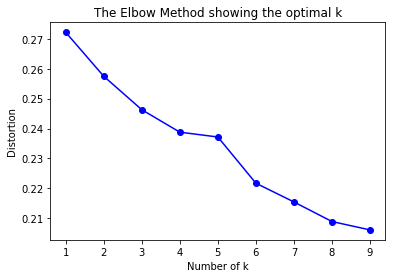

In [69]:
# k means will give us the K
#scipy.spatial.distance.cdist:---->Compute distance between each pair of the two collections of inputs.Returns: Yndarray
import matplotlib as mpl
import matplotlib.pyplot as plt
average_distance_list = []
K = range(1,10)
for k in K:
    KM = KMeans(n_clusters=k).fit(london_grouped_clustering)
    average_distance_list.append(sum(np.min(cdist(london_grouped_clustering,KM.cluster_centers_, 'euclidean'), axis=1)) / london_grouped_clustering.shape[0])


# Plot the elbow
plt.plot(K, average_distance_list, 'bo-')
plt.xlabel('Number of k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Here we can see that we can use 3 since after five the rate of decline in the average distance decreases

Another way to calculate the elbow method is using the library

In [70]:
!pip install yellowbrick

     |████████████████████████████████| 389kB 17.4MB/s eta 0:00:01


/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


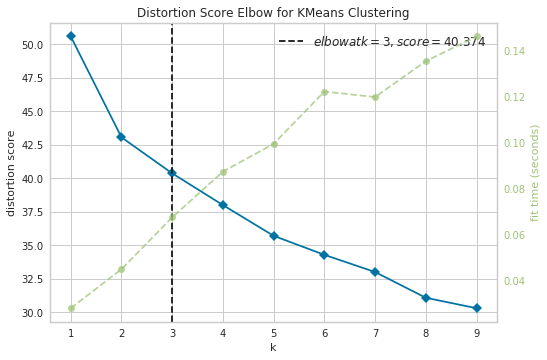

In [71]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))

visualizer.fit(london_grouped_clustering)        # Fit the data to the visualizer
visualizer.show()                                # Finalize and render the figure

In [72]:
# run k-means clustering
kmeans = KMeans(n_clusters=3, random_state=0).fit(london_grouped_clustering)  #random state is for choosing random centers.
#fit can be either dataframe or array using np.asanyarray(df)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 2, 0, 0, 0, 2, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 2, 0, 0, 0, 0, 0, 2, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 1,
       1, 1, 0, 2, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 2, 0, 0, 2, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 2, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,

#### Add the Cluster label on the london_neigh_venues dataframe

In [73]:
# add clustering labels
london_neigh_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)  #insert:Insert column into DataFrame at specified location.
#Parameters:	
#loc : int Insertion index--> Must verify 0 <= loc <= len(columns)
#column : string, number, or hashable object-->label of the inserted column
#value : int, Series, or array-like
london_neigh_venues_sorted.head(5)

,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Abbey Wood,Supermarket,Platform,Historic Site,Coffee Shop,Train Station,Convenience Store,Flea Market,Flower Shop,Food,Food & Drink Shop
1,1,Acton,Gas Station,Miscellaneous Shop,Breakfast Spot,Indian Restaurant,Train Station,Park,Bed & Breakfast,Convenience Store,Grocery Store,Zoo Exhibit
2,2,Addington,Grocery Store,Zoo Exhibit,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest
3,2,Addiscombe,Grocery Store,Zoo Exhibit,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest
4,1,Albany Park,Hotel,Theater,Garden,Monument / Landmark,Plaza,Spa,Wine Bar,Mexican Restaurant,Art Gallery,Sandwich Place


In [74]:
#Let's also see the data we got from wikipedia and their coordinates using geocoder
london_merged = df
london_merged.head()

,Neighbourhood,Borough,Postcode,£/sqft,Latitude,Longitude
0,Bromley,Bromley,BR1,460,51.41671,0.009042
1,Downham,Lewisham,BR1,460,51.41671,0.009042
2,Sundridge,Bromley,BR1,460,51.41671,0.009042
3,Widmore (also Widmore Green),Bromley,BR1,460,51.41671,0.009042
4,Plaistow,Bromley,BR1,460,51.41671,0.009042


In [75]:
#Merge the two above dataframes:Merge london_merged and london_neigh_venues_sorted dataframes

# merge london_grouped with london_data to add latitude/longitude/postcode and £/sqft for each neighborhood
london_merged = london_merged.join(london_neigh_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
london_merged.head() # check the last columns!

,Neighbourhood,Borough,Postcode,£/sqft,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bromley,Bromley,BR1,460,51.41671,0.009042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Downham,Lewisham,BR1,460,51.41671,0.009042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Sundridge,Bromley,BR1,460,51.41671,0.009042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Widmore (also Widmore Green),Bromley,BR1,460,51.41671,0.009042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Plaistow,Bromley,BR1,460,51.41671,0.009042,0.0,Café,Pub,Bus Station,Gym,Convenience Store,Zoo Exhibit,Food Truck,Flower Shop,Food,Food & Drink Shop


#### Now lets drop the rows that do not have a cluster since they did not had venues nearby

In [76]:
london_merged.dropna(inplace=True)

In [77]:
london_merged.reset_index(drop=True,inplace=True)
london_merged.head()

,Neighbourhood,Borough,Postcode,£/sqft,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Plaistow,Bromley,BR1,460,51.41671,0.009042,0.0,Café,Pub,Bus Station,Gym,Convenience Store,Zoo Exhibit,Food Truck,Flower Shop,Food,Food & Drink Shop
1,Hayes,Bromley,BR2,468,51.50642,-0.127210,1.0,Hotel,Theater,Plaza,Garden,Monument / Landmark,Sandwich Place,Mexican Restaurant,Spa,Wine Bar,Art Gallery
2,Southborough,Bromley,BR2,468,51.50642,-0.127210,1.0,Hotel,Theater,Garden,Monument / Landmark,Plaza,Spa,Wine Bar,Mexican Restaurant,Art Gallery,Sandwich Place
3,Leaves Green,Bromley,BR2,468,51.50642,-0.127210,1.0,Hotel,Theater,Garden,Monument / Landmark,Plaza,Spa,Wine Bar,Mexican Restaurant,Art Gallery,Sandwich Place
4,Keston,Bromley,BR2,468,51.50642,-0.127210,1.0,Hotel,Theater,Garden,Monument / Landmark,Plaza,Spa,Wine Bar,Mexican Restaurant,Art Gallery,Sandwich Place


In [78]:
london_merged.dtypes

Neighbourhood              object
Borough                    object
Postcode                   object
£/sqft                     object
Latitude                  float64
Longitude                 float64
Cluster Labels            float64
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

In [79]:
#When you use drop na then the values are converted to floats.Turn them back to integers with the code below:
london_merged['Cluster Labels'] = london_merged['Cluster Labels'].astype(int)
london_merged.dtypes

Neighbourhood              object
Borough                    object
Postcode                   object
£/sqft                     object
Latitude                  float64
Longitude                 float64
Cluster Labels              int64
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

We can aslo see that £/sqft  is an object and particulalry a string so we have to convert it into integer to do our caclulations.The thing is that it has commas.For example in position 123 it has 1,123 price.

In [80]:
#First lets rename the column
london_merged= london_merged.rename(columns={'£/sqft': 'Pounds_per_sqft'})

In [81]:
london_merged['Pounds_per_sqft'] = london_merged['Pounds_per_sqft'].str.replace(',', '')

In [82]:
london_merged['Pounds_per_sqft'] = london_merged['Pounds_per_sqft'].astype(int)

In [83]:
london_merged.dtypes

Neighbourhood              object
Borough                    object
Postcode                   object
Pounds_per_sqft             int64
Latitude                  float64
Longitude                 float64
Cluster Labels              int64
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

In [84]:
london_merged.head()

,Neighbourhood,Borough,Postcode,Pounds_per_sqft,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Plaistow,Bromley,BR1,460,51.41671,0.009042,0,Café,Pub,Bus Station,Gym,Convenience Store,Zoo Exhibit,Food Truck,Flower Shop,Food,Food & Drink Shop
1,Hayes,Bromley,BR2,468,51.50642,-0.127210,1,Hotel,Theater,Plaza,Garden,Monument / Landmark,Sandwich Place,Mexican Restaurant,Spa,Wine Bar,Art Gallery
2,Southborough,Bromley,BR2,468,51.50642,-0.127210,1,Hotel,Theater,Garden,Monument / Landmark,Plaza,Spa,Wine Bar,Mexican Restaurant,Art Gallery,Sandwich Place
3,Leaves Green,Bromley,BR2,468,51.50642,-0.127210,1,Hotel,Theater,Garden,Monument / Landmark,Plaza,Spa,Wine Bar,Mexican Restaurant,Art Gallery,Sandwich Place
4,Keston,Bromley,BR2,468,51.50642,-0.127210,1,Hotel,Theater,Garden,Monument / Landmark,Plaza,Spa,Wine Bar,Mexican Restaurant,Art Gallery,Sandwich Place


Finally, let's visualize the resulting clusters

In [85]:
#create map
kclusters = 3
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]  
#The RGB color model is an additive color model[1] in which red, green, and blue light are added together in various ways to reproduce a broad array of colors.
#rgb2hex: converts rgb to hex
#e,g:
#matplotlib.colors.to_hex([ 0.47, 0.0, 1.0 ])
#out:--->u'#7800ff'

# add markers to the map
markers_colors = []
for lat, lon,postcode, neigh, cluster in zip(london_merged['Latitude'], london_merged['Longitude'],london_merged['Postcode'],london_merged['Neighbourhood'], london_merged['Cluster Labels']):
    label = folium.Popup(str(postcode)+","+str(neigh) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1], #if cluster is 0 then the 1- will lead to a color of #ff0000 in the rainbow list!
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)  #fill_opacity fills the circle.if it is zero the circle is similar to a donut.
       
map_clusters

In [86]:
london_merged.head()

,Neighbourhood,Borough,Postcode,Pounds_per_sqft,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Plaistow,Bromley,BR1,460,51.41671,0.009042,0,Café,Pub,Bus Station,Gym,Convenience Store,Zoo Exhibit,Food Truck,Flower Shop,Food,Food & Drink Shop
1,Hayes,Bromley,BR2,468,51.50642,-0.127210,1,Hotel,Theater,Plaza,Garden,Monument / Landmark,Sandwich Place,Mexican Restaurant,Spa,Wine Bar,Art Gallery
2,Southborough,Bromley,BR2,468,51.50642,-0.127210,1,Hotel,Theater,Garden,Monument / Landmark,Plaza,Spa,Wine Bar,Mexican Restaurant,Art Gallery,Sandwich Place
3,Leaves Green,Bromley,BR2,468,51.50642,-0.127210,1,Hotel,Theater,Garden,Monument / Landmark,Plaza,Spa,Wine Bar,Mexican Restaurant,Art Gallery,Sandwich Place
4,Keston,Bromley,BR2,468,51.50642,-0.127210,1,Hotel,Theater,Garden,Monument / Landmark,Plaza,Spa,Wine Bar,Mexican Restaurant,Art Gallery,Sandwich Place


In [87]:
#### Lets see the bins in our dataframe:
#If you just want them equally distributed, you can simply use range:
#plt.hist(data, bins=range(min(data), max(data) + binwidth, binwidth))

Text(0.5, 1.0, '£/sqft Bins')

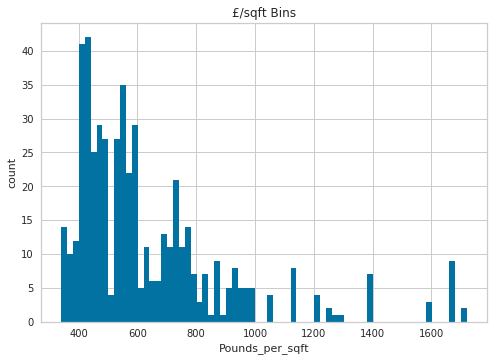

In [91]:
binwidth=20
import matplotlib.pyplot as plt
plt.hist(london_merged["Pounds_per_sqft"],bins=range(min(london_merged["Pounds_per_sqft"]), max(london_merged["Pounds_per_sqft"])+ binwidth, binwidth))
plt.xlabel("Pounds_per_sqft")
plt.ylabel("count")
plt.title("£/sqft Bins")

Lets split the prices in bins of 5:
* Low Price (340-600)£/sqft 
* Medium Price (600-800)£/sqft 
* Above Medium Price (800-1000)£/sqft 
* High Price (1000-1200)£/sqft 
* Luxury Price (1200-and above)£/sqft 

In [92]:
bin_names = ['Low Price','Medium Price','Above Medium Price','High Price','Luxury Price']
print(min(london_merged["Pounds_per_sqft"]))
print(max(london_merged["Pounds_per_sqft"]))

341
1717


In [93]:
bins=[340,600,800,1000,1200,1718]
bins=np.array(bins)
#bins = np.linspace(min(london_merged["Pounds_per_sqft"]), max(london_merged["Pounds_per_sqft"]), 6)
bins

array([ 340,  600,  800, 1000, 1200, 1718])

In [94]:
#Let's add the above to the dataframe:
london_merged['Price_Classification'] = pd.cut(london_merged['Pounds_per_sqft'], bins, labels=bin_names )
london_merged[['Pounds_per_sqft','Cluster Labels','Price_Classification']].head()

,Pounds_per_sqft,Cluster Labels,Price_Classification
0,460,0,Low Price
1,468,1,Low Price
2,468,1,Low Price
3,468,1,Low Price
4,468,1,Low Price


#### Let's see where the most clusters are :

In [95]:
london_merged.groupby(london_merged['Cluster Labels']).count()

,Neighbourhood,Borough,Postcode,Pounds_per_sqft,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Price_Classification
Cluster Labels,,,,,,,,,,,,,,,,,
0,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218,218
1,275,275,275,275,275,275,275,275,275,275,275,275,275,275,275,275,275
2,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19


## <strong><u> Part 5: Examine our Clusters

Since we are only interested on the most common venue we will only use the 1st, 2nd and 3rd most common venues

In [96]:
london_merged.columns

Index(['Neighbourhood', 'Borough', 'Postcode', 'Pounds_per_sqft', 'Latitude',
       'Longitude', 'Cluster Labels', '1st Most Common Venue',
       '2nd Most Common Venue', '3rd Most Common Venue',
       '4th Most Common Venue', '5th Most Common Venue',
       '6th Most Common Venue', '7th Most Common Venue',
       '8th Most Common Venue', '9th Most Common Venue',
       '10th Most Common Venue', 'Price_Classification'],
      dtype='object')

In [97]:
london_merged_final=london_merged[list(london_merged.columns[0:10])+['Price_Classification']]
london_merged_final.head()

,Neighbourhood,Borough,Postcode,Pounds_per_sqft,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Price_Classification
0,Plaistow,Bromley,BR1,460,51.41671,0.009042,0,Café,Pub,Bus Station,Low Price
1,Hayes,Bromley,BR2,468,51.50642,-0.127210,1,Hotel,Theater,Plaza,Low Price
2,Southborough,Bromley,BR2,468,51.50642,-0.127210,1,Hotel,Theater,Garden,Low Price
3,Leaves Green,Bromley,BR2,468,51.50642,-0.127210,1,Hotel,Theater,Garden,Low Price
4,Keston,Bromley,BR2,468,51.50642,-0.127210,1,Hotel,Theater,Garden,Low Price


In [98]:
#Many Neighbourhoods have the same postcodes and thus the same venues around.In order to resolve that we will drop all the rows that have the same Postcode (drop duplicates)
london_merged_final.drop_duplicates(subset='Postcode',inplace=True)
#and then reset the index again
london_merged_final.reset_index(drop=True,inplace=True)
london_merged_final.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Neighbourhood,Borough,Postcode,Pounds_per_sqft,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Price_Classification
0,Plaistow,Bromley,BR1,460,51.416710,0.009042,0,Café,Pub,Bus Station,Low Price
1,Hayes,Bromley,BR2,468,51.506420,-0.127210,1,Hotel,Theater,Plaza,Low Price
2,Bromley Common,Bromley,BR3,483,51.415095,-0.035403,1,Athletics & Sports,Train Station,Park,Low Price
3,West Wickham,Bromley,BR4,458,51.506420,-0.127210,1,Hotel,Theater,Garden,Low Price
4,St Paul's Cray,Bromley,BR5,418,51.506420,-0.127210,1,Hotel,Theater,Garden,Low Price


In [99]:
london_merged_final.shape

(202, 11)

In [100]:
#Let's visualise the map again:
#create map
kclusters = 3
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]  
#The RGB color model is an additive color model[1] in which red, green, and blue light are added together in various ways to reproduce a broad array of colors.
#rgb2hex: converts rgb to hex
#e,g:
#matplotlib.colors.to_hex([ 0.47, 0.0, 1.0 ])
#out:--->u'#7800ff'

# add markers to the map
markers_colors = []
for lat, lon,postcode, neigh, cluster in zip(london_merged_final['Latitude'], london_merged_final['Longitude'],london_merged_final['Postcode'],london_merged_final['Neighbourhood'], london_merged_final['Cluster Labels']):
    label = folium.Popup(str(postcode)+","+str(neigh) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1], #if cluster is 0 then the 1- will lead to a color of #ff0000 in the rainbow list!
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)  #fill_opacity fills the circle.if it is zero the circle is similar to a donut.
       
map_clusters

### Cluster 1

In [105]:
cluster1df= london_merged_final.loc[london_merged_final['Cluster Labels'] == 0]
cluster1df.reset_index(drop=True,inplace=True)
cluster1df

,Neighbourhood,Borough,Postcode,Pounds_per_sqft,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Price_Classification
0,Plaistow,Bromley,BR1,460,51.416710,0.009042,0,Café,Pub,Bus Station,Low Price
1,Elmstead,Bromley,BR7,494,51.413275,0.087473,0,Nature Preserve,Gym Pool,Pub,Low Price
2,Mitcham,Merton,CR4,429,51.402625,-0.143638,0,Fast Food Restaurant,Bus Stop,Park,Low Price
3,Crayford,Bexley,DA1,356,51.452068,0.172230,0,Mediterranean Restaurant,Italian Restaurant,Pub,Low Price
4,Foots Cray,Bexley,DA14,414,51.452068,0.172230,0,Mediterranean Restaurant,Italian Restaurant,Pub,Low Price
5,Barnehurst,Bexley,DA7,404,51.470520,0.146706,0,Pub,Forest,Indian Restaurant,Low Price
6,Mile End,Tower Hamlets,E1,832,51.520220,-0.054310,0,Pub,Brewery,Chinese Restaurant,Above Medium Price
7,Wanstead,Redbridge,E11,580,51.576760,0.027230,0,Café,Bakery,Park,Low Price
8,Plaistow,Newham,E13,435,51.526530,0.028760,0,Café,Pub,Bus Station,Low Price
9,Leamouth,Tower Hamlets,E14,727,51.511220,-0.012640,0,Café,Park,Coffee Shop,Medium Price


We can see from the above dataframe that most of the Neighbourhoods that belong in cluster 1 are low to medium price and are surrounded by restaurants,cafes,coffee shops and pubs

#### Cluster 2

In [106]:
cluster2df= london_merged_final.loc[london_merged_final['Cluster Labels'] == 1]
cluster2df.reset_index(drop=True,inplace=True)
cluster2df

,Neighbourhood,Borough,Postcode,Pounds_per_sqft,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Price_Classification
0,Hayes,Bromley,BR2,468,51.506420,-0.127210,1,Hotel,Theater,Plaza,Low Price
1,Bromley Common,Bromley,BR3,483,51.415095,-0.035403,1,Athletics & Sports,Train Station,Park,Low Price
2,West Wickham,Bromley,BR4,458,51.506420,-0.127210,1,Hotel,Theater,Garden,Low Price
3,St Paul's Cray,Bromley,BR5,418,51.506420,-0.127210,1,Hotel,Theater,Garden,Low Price
4,Chelsfield,Bromley,BR6,461,51.506420,-0.127210,1,Hotel,Theater,Garden,Low Price
5,Selsdon,Croydon,CR2,434,51.506420,-0.127210,1,Hotel,Theater,Garden,Low Price
6,Old Coulsdon,Croydon,CR5,415,51.506420,-0.127210,1,Hotel,Theater,Garden,Low Price
7,Thornton Heath,Croydon,CR7,392,51.396315,-0.106608,1,Grocery Store,Furniture / Home Store,Betting Shop,Low Price
8,Purley,Croydon,CR8,422,51.506420,-0.127210,1,Hotel,Theater,Garden,Low Price
9,Welling,Bexley,DA16,395,51.459075,0.099121,1,Resort,Indian Restaurant,Grocery Store,Low Price


Cluster 2 does not make much of a difference ,however we can see that the most common venue are Grocery Stores and since the Neighbourhoods are not in a central location,the price is low

#### Cluster 3

In [107]:
cluster3df= london_merged_final.loc[london_merged_final['Cluster Labels'] == 2]
cluster3df.reset_index(drop=True,inplace=True)
cluster3df

,Neighbourhood,Borough,Postcode,Pounds_per_sqft,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Price_Classification
0,Woodside,Croydon,CR0,431,51.384755,-0.051499,2,Grocery Store,Zoo Exhibit,Flea Market,Low Price
1,Blackfen,Bexley,DA15,424,51.452281,0.099797,2,Grocery Store,Gastropub,Bus Stop,Low Price
2,Creekmouth,Barking and Dagenham,IG11,401,51.533120,0.084077,2,Grocery Store,Supermarket,Spa,Low Price
3,Bounds Green,Haringey,N11,556,51.616310,-0.138390,2,Grocery Store,Fish & Chips Shop,Bus Stop,Low Price
4,Rush Green,Barking and Dagenham,RM7,365,51.574088,0.167940,2,Racetrack,Grocery Store,Park,Low Price


Finally in cluster 3 we see that we have most of the luxury Neighbourhoods where the most common venues are Hotels,Museums ,Pubs, French,Italian luxury restaurants and exhibits!

## <strong><u> Part 6: Multiple Linear Regression Analysis

We will start working on the London grouped dataframe and df dataframe from above. 

In [514]:
london_grouped.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Betting Shop,Bike Shop,Bistro,Boarding House,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Canal,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Champagne Bar,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cricket Ground,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Knitting Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical School,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Nightclub,Noodle House,North Indian Restaurant,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Palace,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Racetrack,Radio Station,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Recruiting Agency,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Resort,Restaurant,River,Road,Rock Club,Roof Deck,Sake Bar,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shaanxi Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Soccer Field,Soccer Stadium,Social Club,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,

In [515]:
df.head()

,Neighbourhood,Borough,Postcode,£/sqft,Latitude,Longitude
0,Bromley,Bromley,BR1,460,51.41671,0.009042
1,Downham,Lewisham,BR1,460,51.41671,0.009042
2,Sundridge,Bromley,BR1,460,51.41671,0.009042
3,Widmore (also Widmore Green),Bromley,BR1,460,51.41671,0.009042
4,Plaistow,Bromley,BR1,460,51.41671,0.009042


In [516]:
london_merged2= df.join(london_grouped.set_index('Neighbourhood'), on='Neighbourhood')

In [517]:
london_merged2.head()

,Neighbourhood,Borough,Postcode,£/sqft,Latitude,Longitude,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Betting Shop,Bike Shop,Bistro,Boarding House,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Canal,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Champagne Bar,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cricket Ground,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Knitting Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical School,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Nightclub,Noodle House,North Indian Restaurant,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Palace,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Racetrack,Radio Station,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Recruiting Agency,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Resort,Restaurant,River,Road,Rock Club,Roof Deck,Sake Bar,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shaanxi Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Soccer Field,Soccer Stadium,Social Club,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sp

In [518]:
london_merged2.columns

Index(['Neighbourhood', 'Borough', 'Postcode', '£/sqft', 'Latitude',
       'Longitude', 'Accessories Store', 'Afghan Restaurant',
       'African Restaurant', 'American Restaurant',
       ...
       'Vietnamese Restaurant', 'Warehouse Store', 'Windmill', 'Wine Bar',
       'Wine Shop', 'Wings Joint', 'Women's Store', 'Xinjiang Restaurant',
       'Yoga Studio', 'Zoo Exhibit'],
      dtype='object', length=321)

In [519]:
london_merged2.shape

(516, 321)

In [520]:
london_merged2.dropna(inplace=True)
#When you use drop na then the values are converted to floats.Turn them back to integers with the code below:
london_merged2= london_merged2.rename(columns={'£/sqft': 'Pounds_per_sqft'})
london_merged2['Pounds_per_sqft'] = london_merged2['Pounds_per_sqft'].str.replace(',', '')
london_merged2['Pounds_per_sqft'] = london_merged2['Pounds_per_sqft'].astype(int)
london_merged2.drop_duplicates(subset='Postcode',inplace=True)
london_merged2.reset_index(drop=True,inplace=True)
london_merged2.head()

,Neighbourhood,Borough,Postcode,Pounds_per_sqft,Latitude,Longitude,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Betting Shop,Bike Shop,Bistro,Boarding House,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Canal,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Champagne Bar,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cricket Ground,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Knitting Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical School,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Nightclub,Noodle House,North Indian Restaurant,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Palace,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Racetrack,Radio Station,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Recruiting Agency,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Resort,Restaurant,River,Road,Rock Club,Roof Deck,Sake Bar,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shaanxi Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Soccer Field,Soccer Stadium,Social Club,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Good

In [521]:
london_merged2_final=london_merged2[['Neighbourhood']+['Pounds_per_sqft']+list(london_merged2.columns[6:321])]
london_merged2_final.head()

,Neighbourhood,Pounds_per_sqft,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Betting Shop,Bike Shop,Bistro,Boarding House,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Canal,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Champagne Bar,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cricket Ground,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Knitting Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical School,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Nightclub,Noodle House,North Indian Restaurant,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Palace,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Racetrack,Radio Station,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Recruiting Agency,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Resort,Restaurant,River,Road,Rock Club,Roof Deck,Sake Bar,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shaanxi Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Soccer Field,Soccer Stadium,Social Club,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri La

In [522]:
#london_merged2_final.dtypes #From here we can see that all the elements in our dataframe are either floats or integers,thus we can proceed with the regression method

In [523]:
# Normalise the Pounds_per_sqft data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
standardized_price = scaler.fit_transform(london_merged2_final[['Pounds_per_sqft']])
standardized_price[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[-0.62669347],
       [-0.59625628],
       [-0.53918655],
       [-0.63430277],
       [-0.78648872]])

In [524]:
# add the normalized price to the dataframe
london_merged2_final['Standardized_Price'] = standardized_price

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [525]:
london_merged2_final.head()

,Neighbourhood,Pounds_per_sqft,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Betting Shop,Bike Shop,Bistro,Boarding House,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Canal,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Champagne Bar,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cricket Ground,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Knitting Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical School,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Nightclub,Noodle House,North Indian Restaurant,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Palace,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Racetrack,Radio Station,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Recruiting Agency,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Resort,Restaurant,River,Road,Rock Club,Roof Deck,Sake Bar,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shaanxi Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Soccer Field,Soccer Stadium,Social Club,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri La

In [526]:
#Using LinearRegression, we can get the list of coefficient correlations between each type of venue and the average price
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
LR = LinearRegression(normalize=True)
X = london_merged2_final.drop(columns=['Neighbourhood', 'Standardized_Price','Pounds_per_sqft'])
y = london_merged2_final['Standardized_Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

LR.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [527]:
# let's see how well Multiple Linear Regression fit the problem
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
y_pred = LR.predict(X_test)

print('R2-score:', r2_score(y_test, y_pred))
print(" ")
print('Mean Squared Error:', mean_squared_error(y_test, y_pred)) 
print(" ")
print("Regression coefficients:",LR.coef_[0:10])
print(" ")
#Lets also see the intercept,even though it does not give any value added information
print("Regression intercept:",LR.intercept_)

R2-score: -1.1213311866657404e+26
 
Mean Squared Error: 1.2918370416523627e+26
 
Regression coefficients: [ 9.32397300e+14 -1.96499745e+15  1.19958961e+13 -2.82223584e+14
 -2.50058388e+14 -4.06081464e+15 -6.23049459e+13 -7.50848252e+13
  8.83712492e+13 -1.55869867e+14]
 
Regression intercept: -5441458386161.979


In [528]:
#In order to find the maximum positive coefficients we will use numpy.argsort(a, axis=-1, kind=None, order=None):--->Returns the indices that would sort an array.#It essentially gives you the position of the indexes from the smallest to the largest
#Perform an indirect sort along the given axis using the algorithm specified by the kind keyword. It returns an array of indices of the same shape as a that index data along the given axis in sorted order.
#Then we use the array of indexes in order to slice our LR.coef_ array
print('Coefficients with the most negative influence:', LR.coef_[np.argsort(LR.coef_)[:10]])
print("")
print('Venue types with most negative effect:', X.columns[np.argsort(LR.coef_)[:10]].values)

Coefficients with the most negative influence: [-4.06081464e+15 -1.96499745e+15 -1.31912116e+15 -5.04812972e+14
 -4.58518267e+14 -4.41223852e+14 -4.41223852e+14 -2.82223584e+14
 -2.78736703e+14 -2.77664538e+14]

Venue types with most negative effect: ['Arcade' 'Afghan Restaurant' 'Burrito Place' 'Camera Store' 'Salad Place'
 'Xinjiang Restaurant' 'Pool Hall' 'American Restaurant' 'Gourmet Shop'
 'Kids Store']


In [529]:
#Let's perform the same for the venues that have the largest coefficients:
print('Coefficients with the most positive influence:', LR.coef_[np.argsort(-LR.coef_)[:10]])
print("")
print('Venue types with most positive effect:', X.columns[np.argsort(-LR.coef_)[:10]].values)

Coefficients with the most positive influence: [9.99941498e+14 9.32397300e+14 9.03152157e+14 8.82610771e+14
 5.21752633e+14 5.02805597e+14 4.92741558e+14 4.88663604e+14
 4.71642603e+14 4.70090513e+14]

Venue types with most positive effect: ['Food Stand' 'Accessories Store' 'Used Bookstore' 'Bike Shop'
 'Cycle Studio' 'Hobby Shop' 'Champagne Bar' 'Building' 'Community Center'
 'Polish Restaurant']


In [530]:
#Now let's find the venues whose coefficients are insifnificant
abs_coef = abs(LR.coef_)
print('Coefficients that have the least impact:', LR.coef_[np.argsort(abs_coef)[:10]])
print("")
print('Venue types with least effect:', X.columns[np.argsort(abs_coef)[:10]].values)

Coefficients that have the least impact: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Venue types with least effect: ['Sports Club' 'Library' 'Shop & Service' 'Sculpture Garden' 'University'
 'Shopping Plaza' 'Pastry Shop' 'Photography Studio' 'Pilates Studio'
 'Skating Rink']


In [531]:
#We will do the same function in the columns in order to come up with the column names
print('Venue types that affect most the price positively:', X.columns[np.argsort(-LR.coef_)[:10]].values)

Venue types that affect most the price positively: ['Food Stand' 'Accessories Store' 'Used Bookstore' 'Bike Shop'
 'Cycle Studio' 'Hobby Shop' 'Champagne Bar' 'Building' 'Community Center'
 'Polish Restaurant']


Overall the result of the multiple linear regression cannot be used to predict the price of the asset(flat/house) based on the venues near by.R2-score: -1.1213311866657404e+26 is negative and thus our model is not a good predictor of the price.

### Perform PCR

PCR is a regression technique which is based on Principle Component Analysis.One of the most important applications of PCA is for speeding up machine learning algorithms. 

1) Firstly we will perform PCA on the features set to obtain the principle components. Then select a subset for the next step.

2) Secondly we will use regression on the subset of principal components to get a list of coefficient correlations. 

In [583]:
london_merged2_final.head()

,Neighbourhood,Pounds_per_sqft,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Betting Shop,Bike Shop,Bistro,Boarding House,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Canal,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Champagne Bar,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cricket Ground,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Knitting Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical School,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Nightclub,Noodle House,North Indian Restaurant,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Palace,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Racetrack,Radio Station,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Recruiting Agency,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Resort,Restaurant,River,Road,Rock Club,Roof Deck,Sake Bar,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shaanxi Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Soccer Field,Soccer Stadium,Social Club,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri La

In [584]:
X = london_merged2_final.drop(columns=['Neighbourhood', 'Pounds_per_sqft','Standardized_Price'])
y = london_merged2_final['Standardized_Price']

In [585]:
X.head()

,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Betting Shop,Bike Shop,Bistro,Boarding House,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Canal,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Champagne Bar,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cricket Ground,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doner Restaurant,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Knitting Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical School,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Nightclub,Noodle House,North Indian Restaurant,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Outdoor Supply Store,Pakistani Restaurant,Palace,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Racetrack,Radio Station,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Recruiting Agency,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Resort,Restaurant,River,Road,Rock Club,Roof Deck,Sake Bar,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shaanxi Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Soccer Field,Soccer Stadium,Social Club,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stables,Statio

In [586]:
print(X.shape)

(202, 315)


In [587]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize, scale
#sklearn.preprocessing.SCALE:---->Standardizes a dataset along any axis
scale(X).shape

(202, 315)

In [588]:
# First, apply PCA
pca = PCA(svd_solver='auto', random_state=0)  #Fit the model with X and apply the dimensionality reduction on X.
#However in order to do the fit_transform method we should firstly normalize our X data using scale(X)
X_pca = pca.fit_transform(scale(X))
print("X_pca shape is:",X_pca.shape) 

X_pca shape is: (202, 202)


In [590]:
n_component_list = range(1, 203)
r2_list = []
mse_list = []

# Second, Linear Regression
for i in n_component_list:
    lreg = LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(X_pca[:,:i], y, test_size=0.2, random_state=0)
    model = lreg.fit(X_train, y_train)
    # check the result
    y_pred = lreg.predict(X_test)
    r2 = r2_score(y_test, y_pred) # r2 score
    mse = mean_squared_error(y_test, y_pred) # mse
    r2_list.append(r2)
    mse_list.append(mse)
    
scores_df = pd.DataFrame.from_dict(dict([('NComponents', n_component_list),
                                        ('R2', r2_list),
                                        ('MSE', mse_list)]))
scores_df.set_index('NComponents', inplace=True)

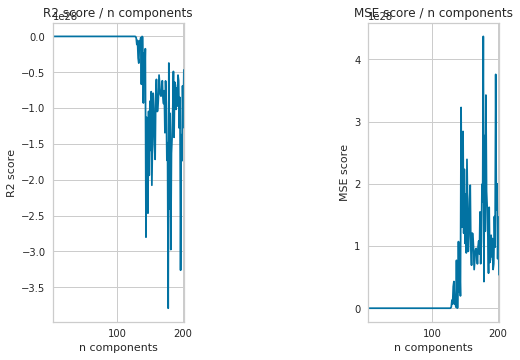

In [591]:
# plot the scores to see the best n_components
plt.subplot(1, 3, 1)   #Seperate the graph to 1 row 3 columns and place the graph in the 1st position
scores_df['R2'].plot(kind='line')
plt.title('R2 score / n components')
plt.ylabel('R2 score')
plt.xlabel('n components')

plt.subplot(1, 3, 3) #Seperate the graph to 1 row 3 columns and place the graph in the 3rd position#Seperate the graph to 1 row 3 columns and place the graph in the 3rd position
scores_df['MSE'].plot(kind='line')
plt.title('MSE score / n components')
plt.ylabel('MSE score')
plt.xlabel('n components')

plt.show()

In [592]:
r2_max = scores_df['R2'].idxmax()
print("Best n:", r2_max, "R2 score:", scores_df['R2'][r2_max])

mse_min = scores_df['MSE'].idxmin()
print("Best n:", mse_min, "MSE:", scores_df['MSE'][mse_min])

Best n: 13 R2 score: 0.7278400791689091
Best n: 13 MSE: 0.31354364452148487


In [597]:
# Use the best n_components parameter
lreg = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X_pca[:,:r2_max], y, test_size=0.2, random_state=0)
model = lreg.fit(X_train, y_train)

# check the result
y_pred = lreg.predict(X_test)
r2 = r2_score(y_test, y_pred) # r2 score
mse = mean_squared_error(y_test, y_pred) # mse
print("R2 score:", r2)
print("MSE:", mse)

R2 score: 0.7278400791689091
MSE: 0.31354364452148487


In [598]:
# Let's try to project the coefs back to the original number of features
#For the coefficient list, the size has been reduced after performing PCA. So, a dot product with eigenvectors is needed to get it back to the original features size.
eigenvectors = pca.components_
pcr_coefs = eigenvectors[:r2_max, :].T @ lreg.coef_

pcr_coefs.shape

(315,)

In [600]:
# Let's check which venue types effect the most and least
print('Coefficients with the most positive influence:' , pcr_coefs[np.argsort(-pcr_coefs)[:10]])
print(" ")
print('Venue types with most positive effect:', X.columns[np.argsort(-pcr_coefs)[:10]].values)
print(" ")
print('Coefficients with the most negative influence:', pcr_coefs[np.argsort(pcr_coefs)[:10]])
print(" ")
print('Venue types with most negative effect:', X.columns[np.argsort(pcr_coefs)[:10]].values)
print(" ")
abs_coef = abs(pcr_coefs)
print('Coefficients with the least impact:', pcr_coefs[np.argsort(abs_coef)[:10]])
print(" ")
print('Coefficients that have the least impact:', X.columns[np.argsort(abs_coef)[:10]].values)

Coefficients with the most positive influence: [0.06645841 0.06289679 0.05487673 0.0500742  0.04599851 0.04562024
 0.0447385  0.04433566 0.04427189 0.04244077]
 
Venue types with most positive effect: ['Modern European Restaurant' 'Salad Place' 'Juice Bar' 'Gift Shop'
 'Recording Studio' 'Kids Store' 'Peruvian Restaurant' 'Souvenir Shop'
 'Speakeasy' 'Cricket Ground']
 
Coefficients with the most negative influence: [-0.02311182 -0.02029252 -0.02013216 -0.01918561 -0.01894229 -0.01813977
 -0.01791299 -0.01740341 -0.01718586 -0.01710827]
 
Venue types with most negative effect: ['Bus Stop' 'North Indian Restaurant' 'Convenience Store' 'Train Station'
 'Monument / Landmark' 'Liquor Store' 'Supermarket' 'Art Museum' 'Park'
 'Church']
 
Coefficients with the least impact: [ 3.37594959e-06  3.37594959e-06 -5.31084390e-05  5.85648461e-05
 -1.46830424e-04 -2.70443051e-04 -3.45769000e-04 -3.95806513e-04
 -4.40554362e-04 -4.86574733e-04]
 
Coefficients that have the least impact: ['Shop & Servi

#### Conclusion:
The result is better than the initial one which was based only on Multiple Linear Regression.Overall we observe that both clustering and Regression methods can be used to predict approximately a neighborhood's average house price per sqft.

### Thank you for reading.

This notebook was created by [Georgios Trakakis](https://www.linkedin.com/in/georgios-trakakis/?originalSubdomain=uk) for the purposes of the [IBM Data Science Professional Specialization](https://www.coursera.org/professional-certificates/ibm-data-science)